In [1]:
! pip install pandas matplotlib seaborn scikit-learn

zsh:1: command not found: pip


## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ORIGINAL_DATASET_PATH = "../dataset/fake_job_postings.csv"

## Data set description

Title → The title or name of the job position being advertised.

Location → The location(s) where the job is based or available. This could include cities, states, or countries.

Department → The specific department or division within the organization to which the job role belongs.

Salary Range → The range of salaries offered for the job position, typically specified as a minimum and maximum value.

Company Profile → A description of the hiring company, including its background, mission, values, products, and services.

Description → A detailed description of the job role, responsibilities, duties, and qualifications required.

Requirements → Specific requirements or qualifications that candidates must meet to be considered for the job, such as education, experience, skills, certifications, etc.

Benefits → Any additional benefits or perks offered to employees, such as health insurance, retirement plans, vacation days, etc.

Telecommuting → Indicates whether the job offers telecommuting or remote work options (1 for yes, 0 for no).

Has Company Logo → Indicates whether the job posting includes the company's logo (1 for yes, 0 for no).

Has Questions → Indicates whether the job posting includes screening questions for applicants (1 for yes, 0 for no).

Employment Type → The type of employment offered for the job, such as full-time, part-time, contract, temporary, etc.

Required Experience → The level of experience required for the job role, such as entry-level, mid-level, senior-level, etc.

Required Education → The minimum education level required for the job, such as high school diploma, bachelor's degree, master's degree, etc.

Industry → The industry or sector to which the job role belongs, such as technology, finance, healthcare, etc.

Function → The specific function or area of specialization within the industry, such as sales, marketing, engineering, etc.

Fraudulent → Indicates whether the job posting is flagged as fraudulent (1 for yes, 0 for no).

## Treating data

In [3]:
data = pd.read_csv(ORIGINAL_DATASET_PATH)

data.head(1)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0


In [4]:
# Drop job_id
data = data.drop(columns=['job_id'])

In [5]:
# Checks duplicates -> tem 281 
data.duplicated().sum()

data = data.drop_duplicates()

# Removed all
data.duplicated().sum()

0

In [6]:
# Check percentage of null value from the features
data.isnull().sum()/len(data)*100

title                   0.000000
location                1.937610
department             64.367294
salary_range           83.936587
company_profile        18.648787
description             0.005682
requirements           15.051992
benefits               40.388658
telecommuting           0.000000
has_company_logo        0.000000
has_questions           0.000000
employment_type        19.478379
required_experience    39.559066
required_education     45.508268
industry               27.484516
function               36.155463
fraudulent              0.000000
dtype: float64

Dealing with missing values 

In [7]:
data.isnull().sum()

title                      0
location                 341
department             11328
salary_range           14772
company_profile         3282
description                1
requirements            2649
benefits                7108
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3428
required_experience     6962
required_education      8009
industry                4837
function                6363
fraudulent                 0
dtype: int64

In [8]:
# Let's fill them with empty value
data.fillna('', inplace = True)
data.isnull().sum()

title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

Making DF for Categorical and Numerical Columns

In [9]:
data.select_dtypes(include='object').columns

Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function'],
      dtype='object')

In [10]:
# Calling Categorical Columns
object_columns_df = data.select_dtypes(include='object')
object_columns_df.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,industry,function
0,Marketing Intern,"US, NY, New York",Marketing,,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Other,Internship,,,Marketing
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Full-time,Not Applicable,,Marketing and Advertising,Customer Service
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,
3,Account Executive - Washington DC,"US, DC, Washington",Sales,,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales
4,Bill Review Manager,"US, FL, Fort Worth",,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider


In [11]:
# Calling Numerical Columns
data.select_dtypes(include=int).columns

Index(['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent'], dtype='object')

In [12]:
numerical_columns_df = data.select_dtypes(include=int)
numerical_columns_df.head()

,telecommuting,has_company_logo,has_questions,fraudulent
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,1,0


### Some Data Visualization

Counts of Fraudulent vs Non-Fraudulent

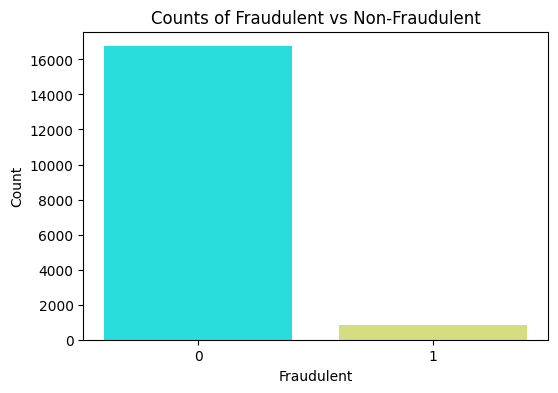

In [20]:
# Counts of Fraudulent vs Non-Fraudulent
fraudulent_counts = data['fraudulent'].value_counts()

plt.figure(figsize=(6,4))
colors = sns.color_palette('rainbow', n_colors=len(fraudulent_counts))
bars = plt.bar(fraudulent_counts.index, fraudulent_counts.values, color=colors)
plt.xlabel('Fraudulent')
plt.ylabel('Count')
plt.title('Counts of Fraudulent vs Non-Fraudulent')

# limiting the x for the 0 and 1 interval
plt.xticks([0,1], fraudulent_counts.index)

plt.show()


Counts of telecommuting vs Non-telecommuting

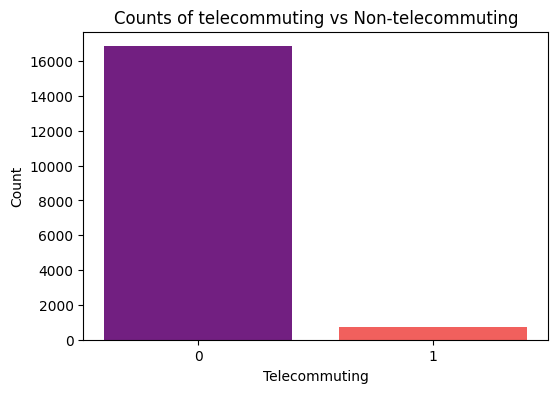

In [22]:
# Counts of telecommuting vs Non-telecommuting
telecommuting_counts = data['telecommuting'].value_counts()

plt.figure(figsize=(6,4))
colors = sns.color_palette('magma', n_colors=len(telecommuting_counts))
bars = plt.bar(telecommuting_counts.index, telecommuting_counts.values, color=colors)
plt.xlabel('Telecommuting')
plt.ylabel('Count')
plt.title('Counts of telecommuting vs Non-telecommuting')

# limiting the x for the 0 and 1 interval
plt.xticks([0,1], telecommuting_counts.index)

plt.show()


Counts of With_Logo vs Without_Logo

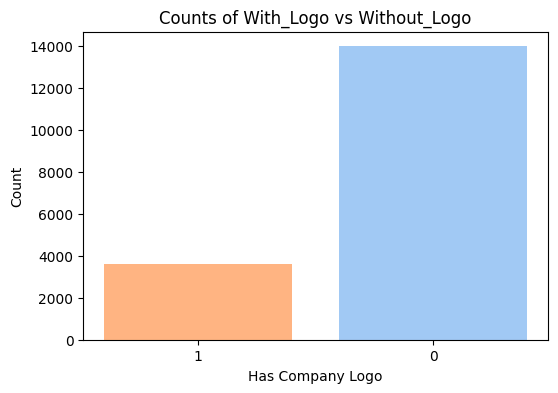

In [25]:
# Counts of With_Logo vs Without_Logo
has_company_logo_counts = data['has_company_logo'].value_counts()

plt.figure(figsize=(6,4))
colors = sns.color_palette('pastel', n_colors=len(has_company_logo_counts))
bars = plt.bar(has_company_logo_counts.index, has_company_logo_counts.values, color=colors)
plt.xlabel('Has Company Logo')
plt.ylabel('Count')
plt.title('Counts of With_Logo vs Without_Logo')

# limiting the x for the 0 and 1 interval
plt.xticks([0,1], has_company_logo_counts.index)

plt.show()
